In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-11-09 11:18:55.608666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762687135.813192      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762687135.868953      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"

train_dir = dataset_dir + "/train"
test_dir = dataset_dir + "/test"

print("Dataset train path:", train_dir)
print("Dataset test path:", test_dir)

Dataset train path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train
Dataset test path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test


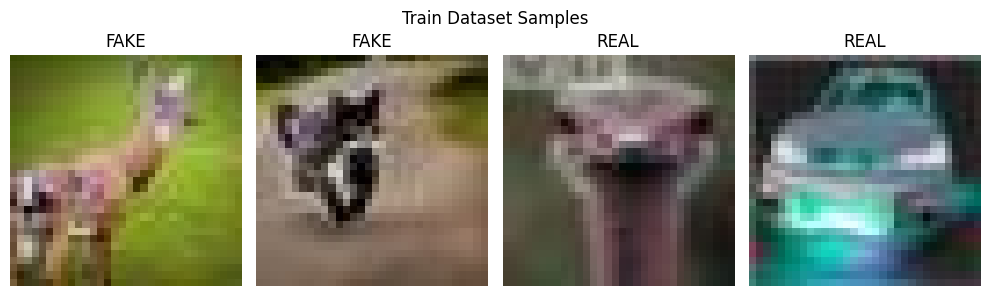

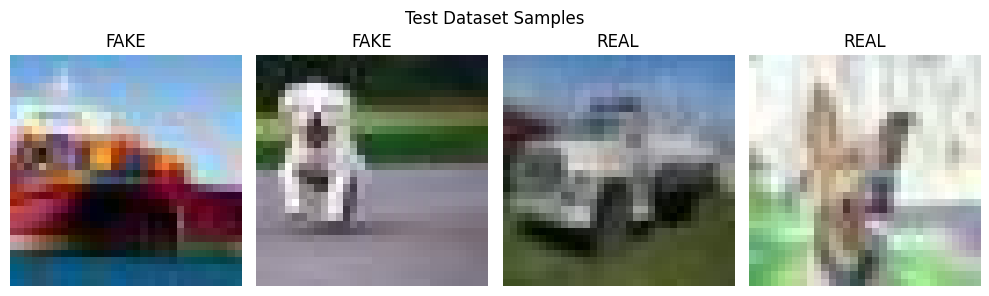

In [3]:
# Ambil beberapa contoh file dari masing-masing kelas
classes = ['FAKE', 'REAL']

def show_examples(base_dir, title):
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    fig.suptitle(title, fontsize=12)

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, cls)
        sample_files = random.sample(os.listdir(cls_dir), 2)
        for j, img_name in enumerate(sample_files):
            img_path = os.path.join(cls_dir, img_name)
            img = mpimg.imread(img_path)
            ax = axes[i*2 + j]
            ax.imshow(img)
            ax.set_title(f"{cls}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan contoh dari train dan test
show_examples(train_dir, "Train Dataset Samples")
show_examples(test_dir, "Test Dataset Samples")

In [4]:
img_height = 32
img_width = 32
batch_size = 64
seed = 42

#load data folder train
full_train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

#Split 90% train dan 10% val
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
val_batches = int(total_batches * 0.1)
train_batches = total_batches - val_batches

train_ds = full_train_ds.take(train_batches)
val_ds = full_train_ds.skip(train_batches)

#Load data test dari folder test (tidak diubah atau diacak)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

#Optimasi pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

def count_images(dataset):
    return sum(batch[0].shape[0] for batch in dataset)

train_count = count_images(train_ds)
val_count = count_images(val_ds)
test_count = count_images(test_ds)

print("Dataset summary:")
print(f"Total batch di folder train: {total_batches}")
print(f"Train batches (90%): {train_batches}")
print(f"Validation batches (10%): {val_batches}")
print(f"Jumlah gambar:")
print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Found 100000 files belonging to 2 classes.


I0000 00:00:1762687273.813086      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 20000 files belonging to 2 classes.
Dataset summary:
Total batch di folder train: 1563
Train batches (90%): 1407
Validation batches (10%): 156
Jumlah gambar:
Train images: 90048
Validation images: 9952
Test images: 20000


In [5]:
class_names = full_train_ds.class_names
print("Urutan kelas:", class_names)


Urutan kelas: ['FAKE', 'REAL']


In [6]:
# Augmentasi Data (Train Saja)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

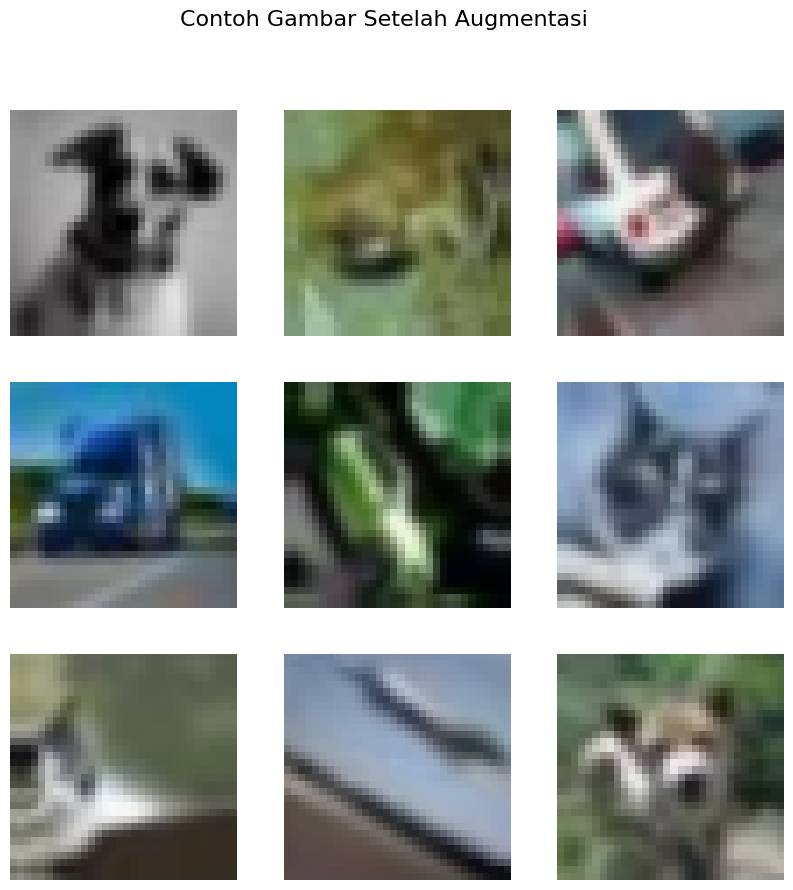

In [7]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented = data_augmentation(images)
        plt.subplot(3, 3, i+1)
        plt.imshow(tf.cast(augmented[i], tf.uint8))  # pakai uint8 biar warna asli
        plt.axis("off")
    plt.suptitle("Contoh Gambar Setelah Augmentasi", fontsize=16)
    plt.show()

In [8]:
imagenet = "/kaggle/input/weights/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [9]:
# ResNet101

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers, models, optimizers

# Tambahkan layer preprocessing
preprocess_layer = layers.Lambda(preprocess_input)

base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights= imagenet,
    input_shape=(img_height, img_width, 3),
    pooling='avg',
    classifier_activation='softmax'
)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(base_model.output)

# Buat model final
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 42,660,225 (162.74 MB)

 Trainable params: 42,554,881 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [10]:
# Training dengan EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100


I0000 00:00:1762687563.928990      66 service.cc:148] XLA service 0x36f7ef80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762687563.929777      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762687572.816450      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1407 ━━━━━━━━━━━━━━━━━━━━ 48:36:15 124s/step - accuracy: 0.4688 - loss: 1.1214 - precision: 0.3871 - recall: 0.4444

I0000 00:00:1762687595.278368      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 223s 70ms/step - accuracy: 0.8306 - loss: 0.4341 - precision: 0.8388 - recall: 0.8149 - val_accuracy: 0.8038 - val_loss: 3.1169 - val_precision: 0.9688 - val_recall: 0.6215
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.8885 - loss: 0.2780 - precision: 0.8877 - recall: 0.8894 - val_accuracy: 0.7823 - val_loss: 0.5691 - val_precision: 0.9682 - val_recall: 0.5768
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.8838 - loss: 0.2930 - precision: 0.8838 - recall: 0.8844 - val_accuracy: 0.8232 - val_loss: 0.4644 - val_precision: 0.9726 - val_recall: 0.6595
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 90s 64ms/step - accuracy: 0.8413 - loss: 0.3837 - precision: 0.8405 - recall: 0.8443 - val_accuracy: 0.8891 - val_loss: 0.3890 - val_precision: 0.9632 - val_recall: 0.8055
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.9060 - loss: 0.2297 - precision: 0.9041 - recall: 0.9089 - val_accuracy: 0.9195 

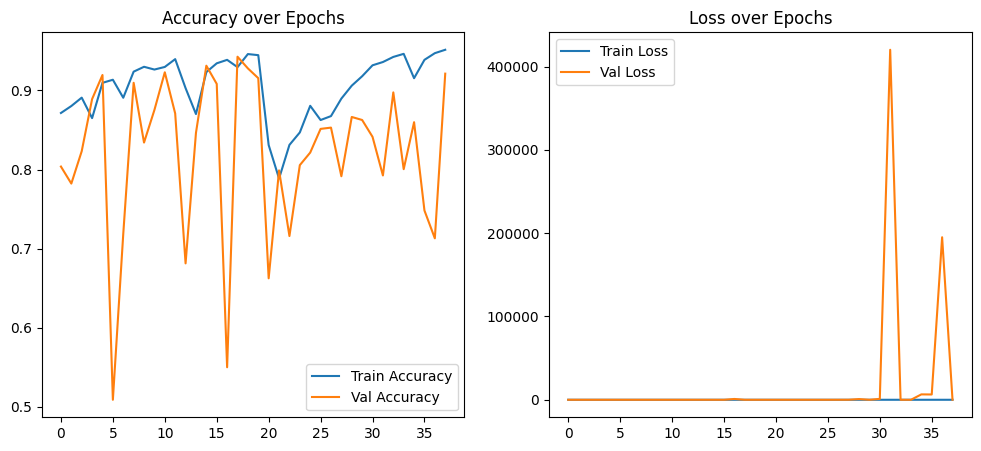

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9311 - loss: 0.1766 - precision: 0.4022 - recall: 0.4798

Test Accuracy: 0.9421
Test Precision: 0.9286
Test Recall: 0.9578
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step


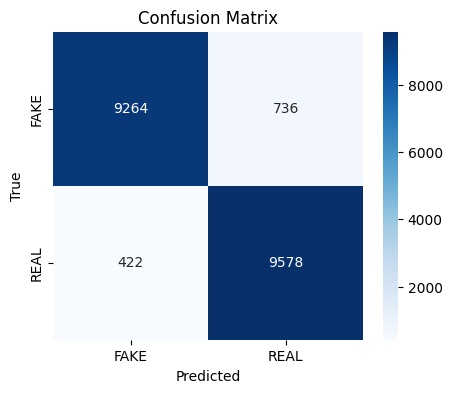


Classification Report:
              precision    recall  f1-score   support

        FAKE       0.96      0.93      0.94     10000
        REAL       0.93      0.96      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [12]:
# 11️Evaluasi di Data Test
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['FAKE', 'REAL']))

In [13]:
model.save("/kaggle/working/resnet101_binary.h5")